In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use('dark_background')

In [2]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

23/05/02 18:58:41 WARN Utils: Your hostname, rig resolves to a loopback address: 127.0.1.1; using 192.168.0.102 instead (on interface enp6s0)
23/05/02 18:58:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/02 18:58:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# PySpark MLlib Algorithms
* **Classiffication (Binary and Multiclass) and Regression:** Linear SVMs, logistic regression,
decision trees, random forests, gradient-boosted trees, naive Bayes, linear least squares, Lasso, ridge regression, isotonic regression
* **Collaborative filtering:** Alternating least squares (ALS)
* **Clustering:** K-means, Gaussian mixture, Bisecting K-means and Streaming K-Means

# The three C's of machine learning in PySpark MLlib
* Collaborative filtering (recommender engines): Produce recommendations
    * Collaborative filtering produces recommendations based on past behavior, preferences, or similarities to known entities/users.
* Classification: identifying to which of a set of categories a new observation
* Clustering: Groups data based on similar characteristics

# PySpark MLlib imports
* pyspark.mllib.recommendation  
`from pyspark.mllib.recommendation import ALS`
* pyspark.mllib.classification  
`from pyspark.mllib.classification import LogisticRegressionWithLBFGS`
* pyspark.mllib.clustering  
`from pyspark.mllib.clustering import KMeans`

In [3]:
# Import the library for ALS
from pyspark.mllib.recommendation import ALS
# Import the library for Logistic Regression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
# Import the library for Kmeans
from pyspark.mllib.clustering import KMeans

# Introduction to Collaborative filtering

## Rating class in pyspark.mllib.recommendation submodule
* The Rating class is a wrapper around tuple (user, product and rating)
* Useful for parsing the RDD and creating a tuple of user, product and rating

In [4]:
from pyspark.mllib.recommendation import Rating
r = Rating(user=1, product=2, rating=5.0)
r

Rating(user=1, product=2, rating=5.0)

In [5]:
r[0], r[1], r[2]

(1, 2, 5.0)

## Splitting the data using randomSplit()
* Splitting data into training and testing sets is important for evaluating predictive modeling
* Typically a large portion of data is assigned to training compared to testing data
* PySpark's randomSplit() method randomly splits with the provided weights and returns multiple RDDs

In [6]:
data = sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
training, test = data.randomSplit([0.6, 0.4])
training.collect()

[1, 3, 6, 7, 8, 9]

In [7]:
test.collect()

[2, 4, 5, 10]

## Alternating Least Squares (ALS)
* Alternating Least Squares (ALS) algorithm in spark.mllib provides collaborative filtering
* ALS.train(ratings, rank, iterations)

The ALS.train() method requires that we represent:
* `ratings` objects as (UserId, ItemId, Rating) tuples along with training parameters rank and iterations.
* `rank` represents the number of features.
* `iterations` represent the number of iterations to run the least squares computation. 

In [8]:
r1 = Rating(1, 1, 1.0)
r2 = Rating(1, 2, 2.0)
r3 = Rating(2, 1, 2.0)
ratings = sc.parallelize([r1, r2, r3])
ratings.collect()

[Rating(user=1, product=1, rating=1.0),
 Rating(user=1, product=2, rating=2.0),
 Rating(user=2, product=1, rating=2.0)]

In [9]:
model = ALS.train(ratings, rank=10, iterations=10)
model

## predictAll() – Returns RDD of Rating Objects
* The predictAll() method returns a list of predicted ratings for input user and product pair
* The method takes in an RDD without ratings to generate the ratings

In [10]:
unrated_RDD = sc.parallelize([(1, 2), (1, 1)])
predictions = model.predictAll(unrated_RDD)
predictions.collect()

[Rating(user=1, product=1, rating=1.0000155759593812),
 Rating(user=1, product=2, rating=1.9890390699464213)]

## Model evaluation using MSE
The MSE is the average value of the square of (actual rating - predicted rating)

In [11]:
rates = ratings.map(lambda x: ((x[0], x[1]), x[2]))
rates.collect()

[((1, 1), 1.0), ((1, 2), 2.0), ((2, 1), 2.0)]

In [12]:
preds = predictions.map(lambda x: ((x[0], x[1]), x[2]))
preds.collect()

[((1, 1), 1.0000155759593812), ((1, 2), 1.9890390699464213)]

In [13]:
rates_preds = rates.join(preds)
rates_preds.collect()

[((1, 2), (2.0, 1.9890390699464213)), ((1, 1), (1.0, 1.0000155759593812))]

In [14]:
MSE = rates_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
MSE

6.007111512497745e-05

## Loading Movie Lens dataset into RDDs

https://grouplens.org/datasets/movielens/100k/

In [15]:
# Load the data into RDD
data = sc.textFile('ratings.csv')
# Split the RDD 
ratings = data.map(lambda l: l.split(','))
# Transform the ratings RDD 
ratings_final = ratings.map(lambda line: Rating(int(line[0]), int(line[1]), float(line[2])))
# Split the data into training and test
training_data, test_data = ratings_final.randomSplit([0.8, 0.2])
training_data.count(), test_data. count()

(80010, 19994)

## Model training and predictions

After splitting the data into training and test data, in the second part of the exercise, you'll train the ALS algorithm using the training data. PySpark MLlib's ALS algorithm has the following mandatory parameters - rank (the number of latent factors in the model) and iterations (number of iterations to run). After training the ALS model, you can use the model to predict the ratings from the test data. For this, you will provide the user and item columns from the test dataset and finally return the list of 2 rows of predictAll() output. 

In [16]:
# Create the ALS model on the training data
model = ALS.train(training_data, rank=10, iterations=10)
# Drop the ratings column 
testdata_no_rating = test_data.map(lambda p: (p[0], p[1]))
testdata_no_rating.count()

19994

In [17]:
# Predict the model  
predictions = model.predictAll(testdata_no_rating)
predictions.count()

19236

`predictAll` retuns fewer rows because of missing training users/products

In [18]:
testdata_df = test_data.map(lambda r: ((r[0], r[1]), r[2])).toDF()
predictions_df = predictions.map(lambda r: ((r[0], r[1]), r[2])).toDF()
testdata_df.join(predictions_df, on='_1', how='leftanti').count()

758

In [19]:
# Return the first 2 rows of the RDD
predictions.take(2)

[Rating(user=529, product=3456, rating=1.455122761716467),
 Rating(user=564, product=320, rating=3.0595998349677433)]

## Model evaluation using MSE

After generating the predicted ratings from the test data using ALS model, in this final part of the exercise, you'll prepare the data for calculating Mean Square Error (MSE) of the model. The MSE is the average value of (original rating – predicted rating)**2 for all users and indicates the absolute fit of the model to the data. To do this, first, you'll organize both the ratings and prediction RDDs to make a tuple of ((user, product), rating)), then join the ratings RDD with prediction RDD and finally apply a squared difference function along with mean() to get the MSE.

In [20]:
# Prepare ratings data
# rates = ratings_final.map(lambda r: ((r[0], r[1]), r[2]))
rates = test_data.map(lambda r: ((r[0], r[1]), r[2]))
# Prepare predictions data
preds = predictions.map(lambda r: ((r[0], r[1]), r[2]))
# (Inner) join the ratings data with predictions data
rates_and_preds = rates.join(preds)
# Calculate and print MSE
MSE = rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error of the model for the test data = {:.2f}".format(MSE))

Mean Squared Error of the model for the test data = 1.31


# Classification

## Working with Vectors
* PySpark MLlib contains specific data types Vectors and LabelledPoint
* Two types of Vectors
    * Dense Vector: store all their entries in an array of floating point numbers
    * Sparse Vector: store only the nonzero values and their indices

In [21]:
from pyspark.mllib.feature import Vectors

In [22]:
denseVec = Vectors.dense([1.0, 2.0, 3.0])
denseVec

DenseVector([1.0, 2.0, 3.0])

In [23]:
sparseVec = Vectors.sparse(4, {1: 1.0, 3: 5.5})
sparseVec

SparseVector(4, {1: 1.0, 3: 5.5})

## LabelledPoint() in PySpark MLlib
* A LabeledPoint is a wrapper for input features and predicted value
* For binary classification of Logistic Regression, a label is either 0 (negative) or 1 (positive)

In [24]:
from pyspark.mllib.feature import LabeledPoint

In [25]:
positive = LabeledPoint(1.0, [1.0, 0.0, 3.0])
negative = LabeledPoint(0.0, [2.0, 1.0, 1.0])
print(positive)
print(negative)

(1.0,[1.0,0.0,3.0])
(0.0,[2.0,1.0,1.0])


## HashingTF() in PySpark MLlib
* HashingTF() algorithm is used to map feature value to indices in the feature vector

In [26]:
from pyspark.mllib.feature import HashingTF

In [27]:
sentence = "hello hello world"
words = sentence.split()
tf = HashingTF(numFeatures=10000)
tf.transform(words)

SparseVector(10000, {1550: 2.0, 3823: 1.0})

## Logistic Regression using `LogisticRegressionWithLBFGS`
* Logistic Regression using Pyspark MLlib is achieved using LogisticRegressionWithLBFGS class

In [28]:
data = [
    LabeledPoint(0.0, [0.0, 1.0]),
    LabeledPoint(1.0, [1.0, 0.0]),
]
RDD = sc.parallelize(data)
lrm = LogisticRegressionWithLBFGS.train(RDD)

23/05/02 18:58:59 WARN Instrumentation: [0a0a04a4] Initial coefficients will be ignored! Its dimensions (1, 2) did not match the expected size (1, 2)


In [29]:
lrm.predict([1.0, 0.0])

1

In [30]:
lrm.predict([0.0, 1.0])

0

## Loading spam and non-spam data

In [31]:
# Load the datasets into RDDs
spam_rdd = sc.textFile('spam.txt')
non_spam_rdd = sc.textFile('ham.txt')
spam_rdd.count(), non_spam_rdd.count()

(747, 4827)

In [32]:
# Split the email messages into words
spam_words = spam_rdd.flatMap(lambda email: email.split(' '))
non_spam_words = non_spam_rdd.flatMap(lambda email: email.split(' '))

# Print the first element in the split RDD
print("The first element in spam_words is", spam_words.first())
print("The first element in non_spam_words is", non_spam_words.first())

The first element in spam_words is You
The first element in non_spam_words is Rofl.


## Feature hashing and LabelPoint

In [33]:
# Create a HashingTf instance with 200 features
tf = HashingTF(numFeatures=200)

# Map each word to one feature
spam_features = tf.transform(spam_words)
non_spam_features = tf.transform(non_spam_words)
spam_features.count(), non_spam_features.count()

(17893, 69642)

In [34]:
# Label the features: 1 for spam, 0 for non-spam
spam_samples = spam_features.map(lambda features: LabeledPoint(1, features))
non_spam_samples = non_spam_features.map(lambda features: LabeledPoint(0, features))

# Combine the two datasets
# samples = spam_samples.join(non_spam_samples)
samples = spam_samples.union(non_spam_samples)

## Logistic Regression model training

In [35]:
# Split the data into training and testing
train_samples,test_samples = samples.randomSplit([0.8, 0.2])

# Train the model
model = LogisticRegressionWithLBFGS.train(train_samples) # <<<<< TypeError: 'LabeledPoint' object is not subscriptable

# Create a prediction label from the test data
predictions = model.predict(test_samples.map(lambda x: x.features))

# Combine original labels with the predicted labels
labels_and_preds = test_samples.map(lambda x: x.label).zip(predictions)

# Check the accuracy of the model on the test data
accuracy = labels_and_preds.filter(lambda x: x[0] == x[1]).count() / float(test_samples.count())
print("Model accuracy : {:.2f}".format(accuracy))

23/05/02 18:59:01 WARN Instrumentation: [90c54ba9] Initial coefficients will be ignored! Its dimensions (1, 200) did not match the expected size (1, 200)


Model accuracy : 0.82


# Introduction to Clustering

## What is Clustering?
* Clustering is the unsupervised learning task to organize a collection of data into groups
* PySpark MLlib library currently supports the following clustering models
    * K-means (most popular method)
    * Gaussian mixture
    * Power iteration clustering (PIC)
    * Bisecting k-means
    * Streaming k-means

## K-means with Spark MLLib

In [36]:
from itertools import islice
skip_rows = 1
RDD = sc.textFile('WineData.csv')\
        .mapPartitionsWithIndex(lambda i, iter: islice(iter, skip_rows, None) if i == 0 else iter)\
        .map(lambda x: x.split(","))\
        .map(lambda x: [float(x[0]), float(x[1])])
    
RDD.take(5)

[[7.4, 0.7], [7.8, 0.88], [7.8, 0.76], [11.2, 0.28], [7.4, 0.7]]

## Train a K-means clustering model
* Training K-means model is done using KMeans.train() method

In [37]:
from pyspark.mllib.clustering import KMeans
model = KMeans.train(RDD, k = 2, maxIterations = 10)
model.clusterCenters

[array([7.44568221, 0.55474957]), array([10.61451247,  0.45710884])]

## Evaluating the K-means Model

In [38]:
from math import sqrt
def error(point):
    center = model.centers[model.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = RDD.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 1315.4149702508378


## Visualizing clusters

In [39]:
wine_data_df = spark.createDataFrame(RDD, schema=["col1", "col2"])
wine_data_df_pandas = wine_data_df.toPandas()
wine_data_df_pandas

,col1,col2
0,7.4,0.700
1,7.8,0.880
2,7.8,0.760
3,11.2,0.280
4,7.4,0.700
...,...,...
1594,6.2,0.600
1595,5.9,0.550
1596,6.3,0.510
1597,5.9,0.645


In [40]:
cluster_centers_pandas = pd.DataFrame(model.clusterCenters, columns=["col1", "col2"])
cluster_centers_pandas.head()

,col1,col2
0,7.445682,0.554750
1,10.614512,0.457109


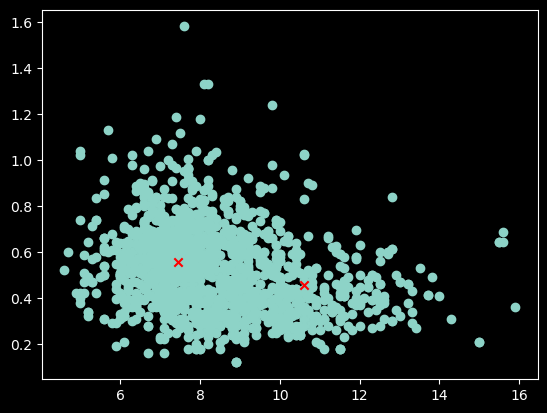

In [41]:
plt.scatter(wine_data_df_pandas["col1"], wine_data_df_pandas["col2"]);
plt.scatter(cluster_centers_pandas["col1"], cluster_centers_pandas["col2"], color="red", marker="x")

## Exercises

### Loading and parsing the 5000 points data

In [42]:
# Load the dataset into an RDD
clusterRDD = sc.textFile('5000_points.txt')
# Split the RDD based on tab
rdd_split = clusterRDD.map(lambda x: x.split('\t'))
# Transform the split RDD by creating a list of integers
rdd_split_int = rdd_split.map(lambda x: [int(x[0]), int(x[1])])
# Count the number of rows in RDD 
print("There are {} rows in the rdd_split_int dataset".format(rdd_split_int.count()))

There are 5000 rows in the rdd_split_int dataset


### K-means training

In [43]:
# Train the model with clusters from 13 to 16 and compute WSSSE
for clst in range(13, 17):
    model = KMeans.train(rdd_split_int, clst)
    WSSSE = rdd_split_int.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("The cluster {} has Within Set Sum of Squared Error {}".format(clst, WSSSE))

The cluster 13 has Within Set Sum of Squared Error 276964198.80208665
The cluster 14 has Within Set Sum of Squared Error 249534250.41062492
The cluster 15 has Within Set Sum of Squared Error 207349106.10454482
The cluster 16 has Within Set Sum of Squared Error 167880388.56492716


In [44]:
# Train the model again with the best k
model = KMeans.train(rdd_split_int, k=15, seed=1)
# Get cluster centers
cluster_centers = model.clusterCenters
cluster_centers

[array([417799.69426752, 787001.99363057]),
 array([852058.45259939, 157685.52293578]),
 array([858947.9713467 , 546259.65902579]),
 array([398555.94857143, 404855.06857143]),
 array([507818.31339031, 175610.41595442]),
 array([167856.14071856, 347812.71556886]),
 array([337565.11890244, 562157.17682927]),
 array([139682.37572254, 558123.40462428]),
 array([320602.55, 161521.85]),
 array([244654.8856305 , 847642.04105572]),
 array([801616.78164557, 321123.34177215]),
 array([606574.95622896, 574455.16835017]),
 array([823421.2507837 , 731145.27272727]),
 array([617601.91071429, 399504.21428571]),
 array([670929.06818182, 862765.73295455])]

## Visualizing clusters

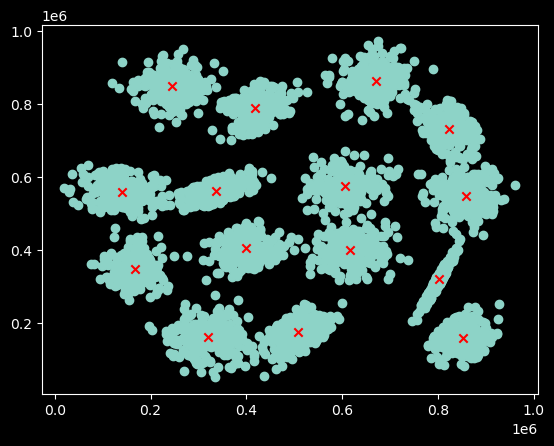

In [45]:
# Convert rdd_split_int RDD into Spark DataFrame and then to Pandas DataFrame
rdd_split_int_df_pandas = spark.createDataFrame(rdd_split_int, schema=["col1", "col2"]).toPandas()
# Convert cluster_centers to a pandas DataFrame
cluster_centers_pandas = pd.DataFrame(model.clusterCenters, columns=["col1", "col2"])
# Create an overlaid scatter plot of clusters and centroids
plt.scatter(rdd_split_int_df_pandas["col1"], rdd_split_int_df_pandas["col2"])
plt.scatter(cluster_centers_pandas["col1"], cluster_centers_pandas["col2"], color="red", marker="x")
plt.show()